Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 64, 64, 3)     256         batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 24)    0           activation_1[0][0]               
___________________________________________________________________________________________

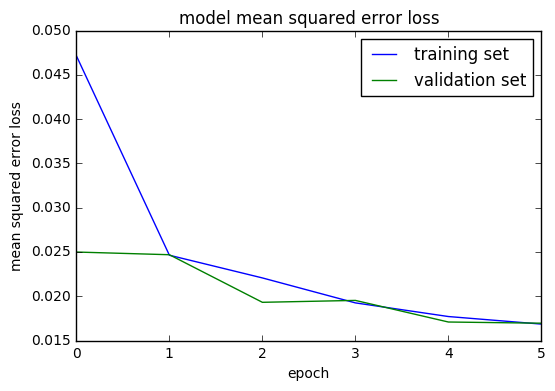

In [1]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.misc
from scipy.stats import bernoulli

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Lambda, BatchNormalization
from keras.optimizers import Adam


def generator(batch_size = 64):

    while True:

        angle_correction = 0.2
        image_files_and_angles = []

        data = pd.read_csv('./data/driving_log.csv')

        for i in np.random.randint(0, len(data), batch_size):

            rnd = np.random.randint(0, 3)

            if rnd == 0:
                image_files_and_angles.append((data.iloc[i]['left'].strip(), data.iloc[i]['steering'] + angle_correction))

            elif rnd == 1:
                image_files_and_angles.append((data.iloc[i]['center'].strip(), data.iloc[i]['steering']))

            else:
                image_files_and_angles.append((data.iloc[i]['right'].strip(), data.iloc[i]['steering'] - angle_correction))

        X_train = []
        y_train = []

        for img_file, angle in image_files_and_angles:

            image = plt.imread('./data/' + img_file)

            if bernoulli.rvs(0.9) == 1: # 0.9: shearing probability
                image, angle = rnd_shear(image, angle)

            image = crop(image, 0.35, 0.1)  # 0.35: top crop percentage, 0.1: bottom crop percentage
            image, angle = flip(image, angle)
            image = rnd_gamma(image)
            image = scipy.misc.imresize(image, (batch_size, batch_size))  # (64, 64) resizing dimension

            X_train.append(image)
            y_train.append(angle)

        yield np.array(X_train), np.array(y_train)


def rnd_shear(image, angle):

    range = 200
    rows, cols, ch = image.shape

    delta_x = np.random.randint(-range, range + 1)
    delta_steer = delta_x / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    m = cv2.getAffineTransform(np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]]), np.float32([[0, rows], [cols, rows], [cols / 2 + delta_x, rows / 2]]))

    image = cv2.warpAffine(image, m, (cols, rows), borderMode = 1)
    angle += delta_steer

    return image, angle


def crop(image, top_percent, bottom_percent):

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

    return image[top:bottom, :]


def flip(image, angle):

    if bernoulli.rvs(0.5):  # 0.5: flip probability
        return np.fliplr(image), -1 * angle
    else:
        return image, angle


def rnd_gamma(image):

    table = np.array([((i / 255.0) ** (1.0 / np.random.uniform(0.4, 1.5))) * 255 for i in np.arange(0, 256)]).astype("uint8")
   
    return cv2.LUT(image, table)  # apply gamma correction using the lookup table


# CNN model is based on NVIDIA:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

model = Sequential()

# Normalize the data
#model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))
model.add(BatchNormalization(input_shape = (64, 64, 3), axis = 1))

# starts with five convolutional and maxpooling layers
model.add(Convolution2D(24, 5, 5, border_mode = 'same', subsample = (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode = 'same', subsample = (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode = 'same', subsample = (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode = 'same', subsample = (1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode = 'same', subsample = (1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1)))

model.add(Flatten())

model.add(Dense(1164))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))

model.add(Dense(1))

model.summary()

model.compile(optimizer = Adam(lr = 0.0001), loss = "mse")
print('Model compiled.')


print('Start training...')

train_generator = generator()
validation_generator = generator()

history_object = model.fit_generator(train_generator, samples_per_epoch = 19200, nb_epoch = 6, validation_data = validation_generator, nb_val_samples = 6400, verbose = 1)

model.save('model.h5')
print('Model saved.')


### Print the keys contained in the history object
print()
print(history_object.history.keys())
print()

### Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc = 'upper right')
plt.show()


from keras import backend
backend.clear_session() # Clear memory of tensorflow


In [ ]:
from subprocess import call
call(["python", "drive.py", "model.h5", "run1"])

In [ ]:
from subprocess import call
call(["python", "video.py", "run1"])